In [1]:
import contextlib
import os
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd
import pycountry
import seaborn as sns

In [2]:
QUERY_ALL = """
SELECT 
    Users.user_id AS user_id, 
    Users.creation_time AS user_creation_time, 
    Tweets.creation_time AS tweet_creation_time,
    Tweets.tweet_id,
    Tweets.full_text,
    Tweets.lang,
    Tweets.country_code,
    Tweets.sentiment_score
FROM Users
INNER JOIN Tweets ON Users.user_id = Tweets.user_id;
"""

QUERY_CONVERSATIONS = """
SELECT * FROM Conversations;
"""

DTYPES = {
"user_id": "object",
"tweet_id": "object",
"full_text": "object",
"lang": "category",
"country_code": "category",
"sentiment_score": "float32",
}

COMPANY_NAME_TO_ID = {
    "Klm": "56377143",
    "Air France": "106062176",
    "British Airways": "18332190",
    "American Air": "22536055",
    "Lufthansa": "124476322",
    "Air Berlin": "26223583",
    "Air Berlin assist": "2182373406",
    "easyJet": "38676903",
    "Ryanair": "1542862735",
    "Singapore Airlines": "253340062",
    "Qantas": "218730857",
    "Etihad Airways": "45621423",
    "Virgin Atlantic": "20626359",
}
COMPANY_ID_LIST = list(COMPANY_NAME_TO_ID.values())
COMPANY_NAME_LIST = list(COMPANY_NAME_TO_ID.keys())
COMPANY_ID_TO_NAME = {v: k for k, v in COMPANY_NAME_TO_ID.items()}

In [3]:
def get_full_language_name(language_code: str,
                           default: str="Undefined Language") -> str:
    """
    Convert a two-letter language code (ISO 639-1) to its full language name.
    
    Parameters:
    language_code (str): The two-letter ISO 639-1 language code.
    
    Returns:
    str: The full name of the language or a message indicating the code was not found.
    """
    if language_code=="Other languages":
        return language_code
    language = pycountry.languages.get(alpha_2=language_code, default=default)
    if language != default:
        language = language.name
    return language


def get_country_name(country_code: str, default: str="Unknown Country") -> str:
    """
    Convert a two-letter country code (ISO 3166-1 alpha-2|) to its full country name.
    
    Parameters:
    country_code (str): The two-letter ISO 3166-1 alpha-2 country code.
    
    Returns:
    str: The full name of the country or a message indicating the code was not found.
    """
    country = pycountry.countries.get(alpha_2=country_code, default=default)
    if country != default:
        country = country.name
    return country

def get_tweets_with_users(query: str, path: str) -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection,
                                 dtype=DTYPES,
                                 parse_dates=["tweet_creation_time", "user_creation_time"],
                                 index_col='tweet_id')


def get_conversations(query: str, path: str) -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection,
                                 dtype={"conversation_id": "object", "tweet_order": "int16", "tweet_id": "object"},
                                 index_col=["conversation_id", "tweet_order"])

In [4]:
path =  os.path.join(
    os.path.dirname(
            os.getcwd()
        ),
    "data_processed", "local_backup.db")
df_tweets_and_users = get_tweets_with_users(QUERY_ALL, path)
df_conversations = get_conversations(QUERY_CONVERSATIONS, path)

In [5]:
df_tweets_and_users

,user_id,user_creation_time,tweet_creation_time,full_text,lang,country_code,sentiment_score
tweet_id,,,,,,,
1131172858951024641,393374091,2011-10-18 12:55:25+00:00,2019-05-22 12:20:00+00:00,La ruta de easyJet entre Londres y Menorca tra...,es,un,-0.037224
1130922003702177800,880417607865815040,2017-06-29 13:28:09+00:00,2019-05-21 19:43:11+00:00,@goody_tracy Here’s a list of some of @JonesDa...,en,un,-0.045324
1131172864147808257,3420691215,2015-08-13 19:18:07+00:00,2019-05-22 12:20:01+00:00,RT @bttr_as1: @goody_tracy Here’s a list of so...,en,un,-0.051741
1131172867985485824,394376606,2011-10-20 00:02:49+00:00,2019-05-22 12:20:02+00:00,@British_Airways,und,un,-0.033292
1131030279278063616,227687574,2010-12-17 14:37:53+00:00,2019-05-22 02:53:26+00:00,Nice change by @AmericanAir. Bikes now pay sta...,en,un,-0.047510
...,...,...,...,...,...,...,...
1244696703690772485,278698748,2011-04-07 19:55:35+00:00,2020-03-30 18:43:14+00:00,RT @jfergo86: Me parece a mí o el avión es más...,es,un,-0.386010
1244696708983984131,246520593,2011-02-02 23:06:38+00:00,2020-03-30 18:43:15+00:00,Today’s random pic of the day is the one of Vo...,en,un,0.872379
1244696710447800320,109284383,2010-01-28 15:09:19+00:00,2020-03-30 18:43:15+00:00,RT @SchipholWatch: @spbverhagen @markduursma @...,nl,un,-0.553437


In [6]:
df_conversations

tweet_id
conversation_id tweet_order                     
1               1            1244694453190897664
                2            1244696682979303426
2               1            1244677304598609923
                2            1244696641401163776
3               1            1244644204132909060
...                                          ...
493694          3             452657442057646080
493695          1             451124070730719233
                2             451125255294443521
493696          1             430790355962052608
                2             430792524043931648

[1346566 rows x 1 columns]

In [7]:
df_all = df_conversations.merge(df_tweets_and_users, left_on='tweet_id', right_index=True, how='left')
df_all

tweet_id             user_id  \
conversation_id tweet_order                                            
1               1            1244694453190897664           521835883   
                2            1244696682979303426            20626359   
2               1            1244677304598609923           396021583   
                2            1244696641401163776  832964639436701696   
3               1            1244644204132909060           274980475   
...                                          ...                 ...   
493694          3             452657442057646080          2198564846   
493695          1             451124070730719233           701977520   
                2             451125255294443521            22536055   
493696          1             430790355962052608            64327804   
                2             430792524043931648            22536055   

                                   user_creation_time  \
conversation_id tweet_order                             
1               1           2012-03-12 01:11:22+00:00   
                2           2009-02-11 20:50:56+00:00   
2               1           2011-10-22 16:35:05+00:00   
                2           2017-02-18 14:47:00+00:00   
3               1           2011-03-31 11:55:53+00:00   
...                                               ...   
493694          3           2013-11-16 23:24:47+00:00   
493695          1           2012-07-17 23:34:18+00:00   
                2           2009-03-02 21:23:05+00:00   
493696          1           2009-08-10 03:34:27+00:00   
                2           2009-03-02 21:23:05+00:00   

                                  tweet_creation_time  \
conversation_id tweet_order                             
1               1           2020-03-30 18:34:17+00:00   
                2           2020-03-30 18:43:09+00:00   
2               1           2020-03-30 17:26:09+00:00   
                2           2020-03-30 18:42:59+00:00   
3               1           2020-03-30 15:14:37+00:00   
...                                               ...   
493694          3           2014-04-06 04:01:58+00:00   
493695          1           2014-04-01 22:28:54+00:00   
                2           2014-04-01 22:33:37+00:00   
493696          1           2014-02-04 19:49:59+00:00   
                2           2014-02-04 19:58:36+00:00   

                                                                     full_text  \
conversation_id tweet_order                                                      
1               1            @nealrach @VirginAtlantic Siiiigh.... Still no...   
                2            @Jade_Velveteese Hi Jade. We have an ‘Away fro...   
2               1            @VirginAtlantic Sod off your primary sharehold...   
                2            @Boyde11 @VirginAtlantic Get your facts right,...   
3               1                              @easyJet Please reply to my DM!   
...                                                                        ...   
493694          3                     @AmericanAir They cannot hear my screams   
493695          1            @AmericanAir i was kidding thanks for the foll...   
                2            @lanaupdates_ Your information has been forwar...   
493696          1            @AmericanAir phew, they finally turned on the ...   
                2            @benjy_greenberg It looks like we'll have you ...   

                            lang country_code  sentiment_score  
conversation_id tweet_order                                     
1               1             en           un         0.292771  
                2             en           un         0.190686  
2               1             en           un        -0.909571  
                2             en           un         0.058692  
3               1             en           un         0.076921  
...                          ...          ...              ...  
493694          3             en

# Conversations

## Number and length of conversations

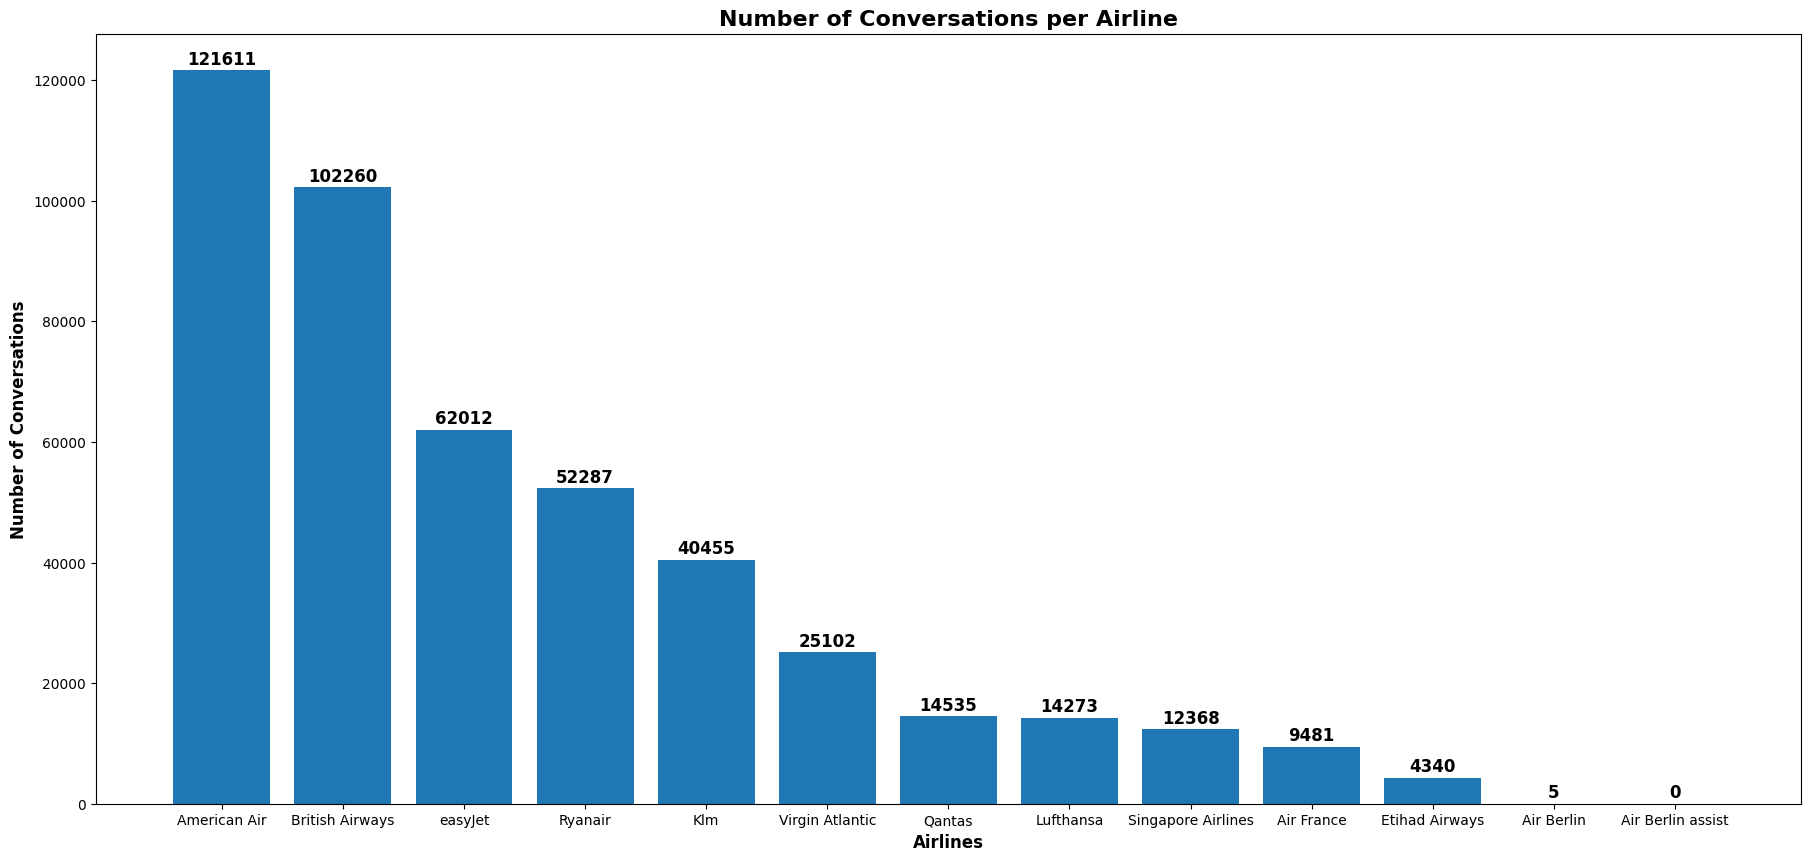

In [8]:
# Reset index to access columns easily
df_reset = df_all.reset_index()

# Dictionary to store the number of conversations per user
user_conversations_count = {}

# Calculate the number of conversations per user
for user_id in COMPANY_ID_LIST:
    # Filter the DataFrame to include only rows where the specific user is involved
    filtered_df = df_reset[df_reset['user_id'] == user_id]
    
    # Identify unique conversation IDs
    unique_conversations = filtered_df['conversation_id'].unique()
    
    # Count the number of unique conversations
    num_unique_conversations = len(unique_conversations)
    
    # Store the count in the dictionary
    name = COMPANY_ID_TO_NAME[user_id]
    user_conversations_count[name] = num_unique_conversations

sorted_user_conversations_count = dict(sorted(user_conversations_count.items(), key=lambda item: item[1], reverse=True))
# Create a bar chart
plt.figure(figsize=(22, 10))
# colors = viridis(range(len(sorted_user_conversations_count)))
bars = plt.bar(sorted_user_conversations_count.keys(), sorted_user_conversations_count.values())
plt.xlabel('Airlines', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Airline', fontsize=16, weight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')

Text(0.5, 1.0, 'Distribution of Conversations by Number of Tweets')

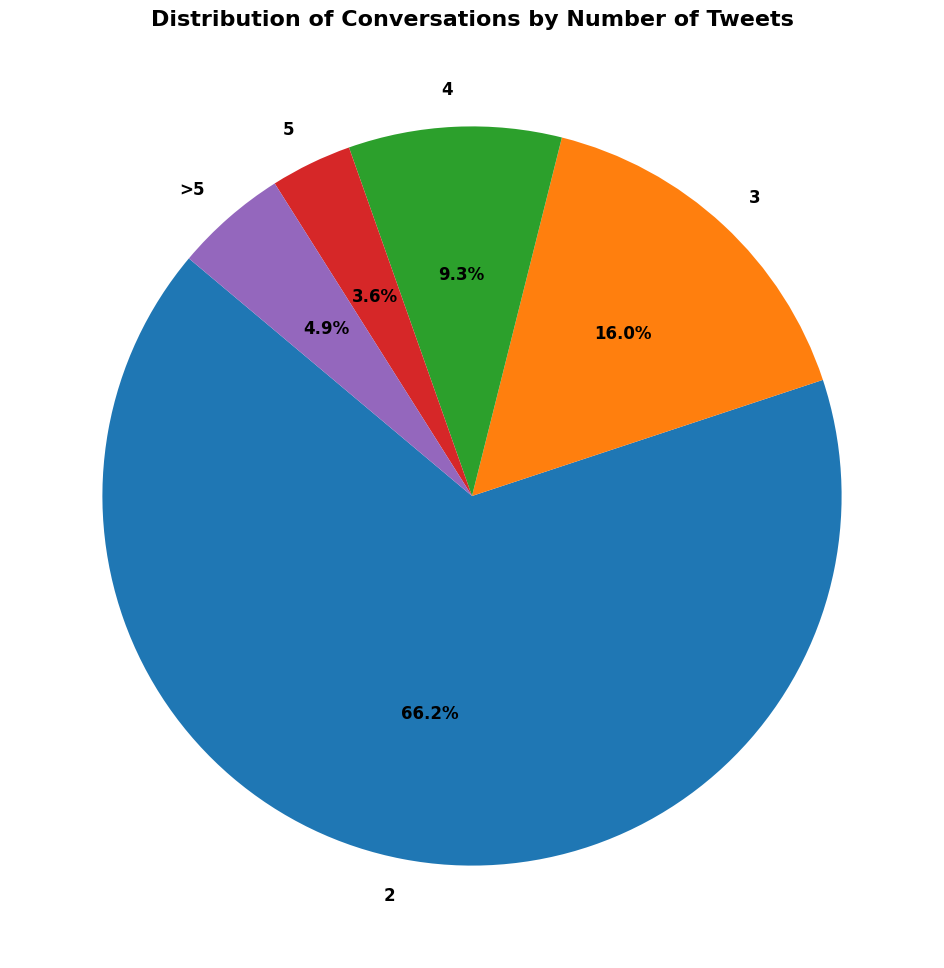

In [9]:

# Assuming df_reset is already available
# Group by conversation_id and count the number of tweets per conversation
conversation_counts = df_reset.groupby('conversation_id').size()

# Group conversations with more than 5 tweets into a single category
conversation_counts = conversation_counts.apply(lambda x: str(x) if x <= 5 else '>5')

# Count the number of conversations for each unique number of tweets
conversation_counts_dist = conversation_counts.value_counts().sort_index()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the pie chart
plt.figure(figsize=(12, 12))
patches, texts, autotexts = plt.pie(conversation_counts_dist, labels=conversation_counts_dist.index, colors=colors[:len(conversation_counts_dist)], autopct='%1.1f%%', startangle=140)

# Set the font properties for labels and autotexts
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.title('Distribution of Conversations by Number of Tweets', fontsize=16, fontweight='bold')

# Add legend


## Time patters

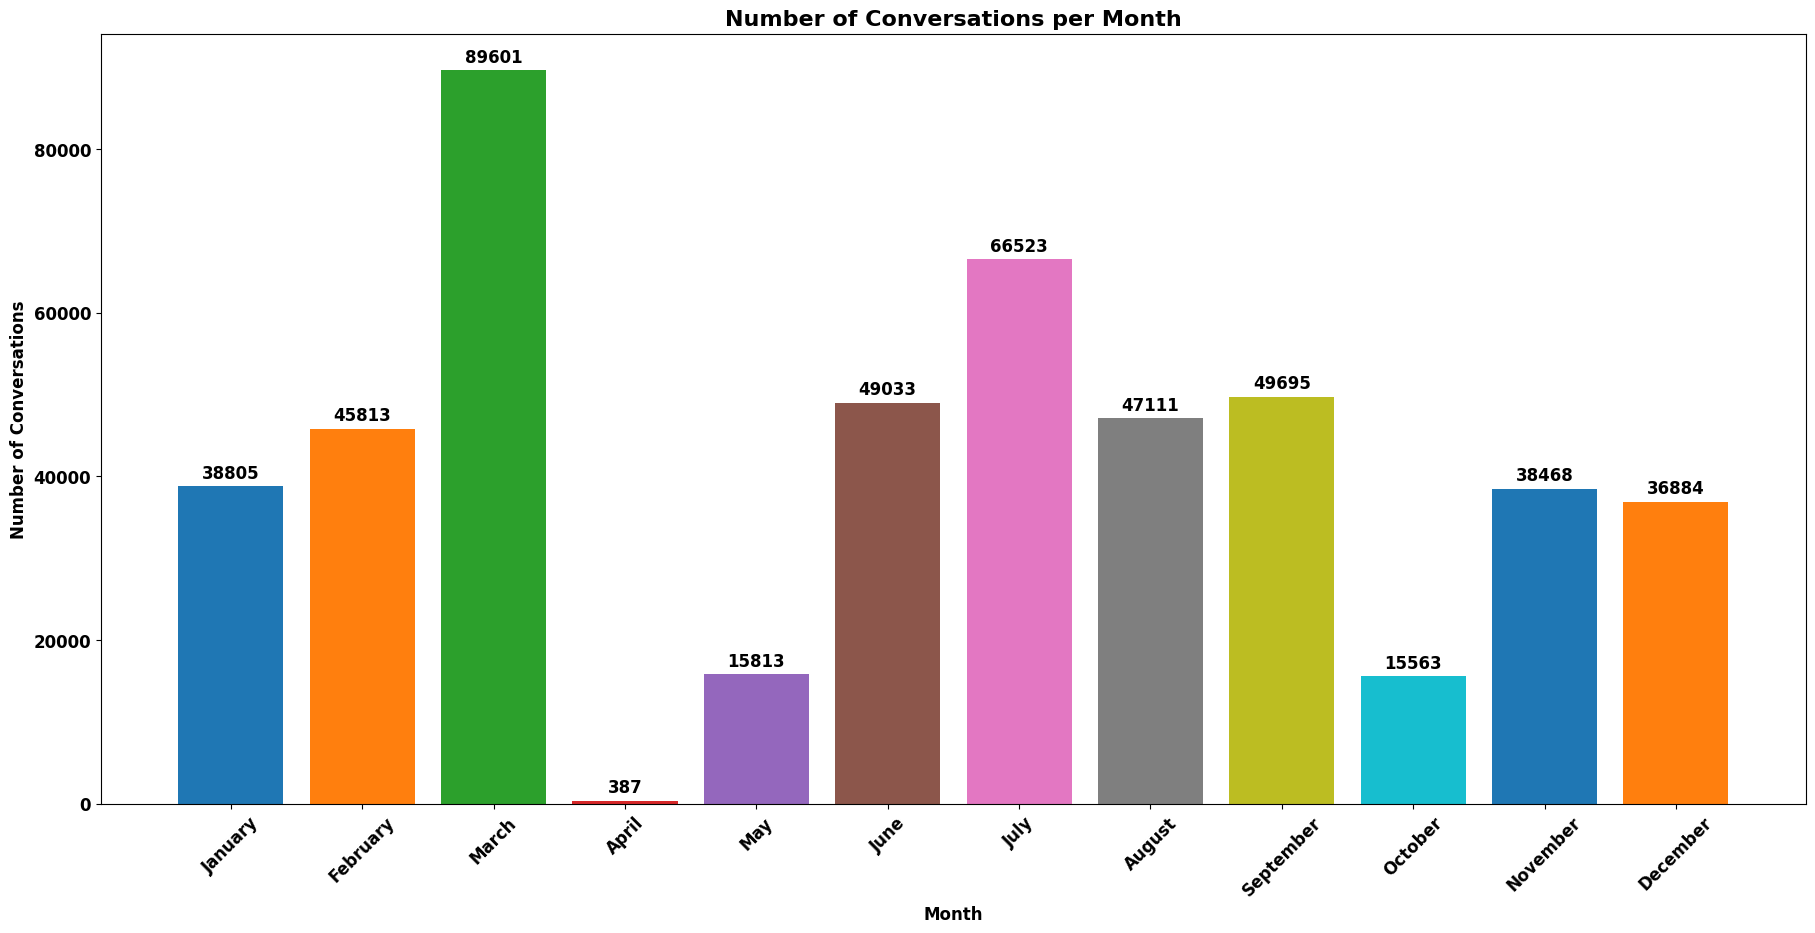

In [10]:
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the month name from the tweet creation time
first_tweet_times_month = first_tweet_times.dt.month_name()

# Group by month name and count the number of conversations
conversations_per_month = first_tweet_times_month.value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(22, 10))
bars = plt.bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold');


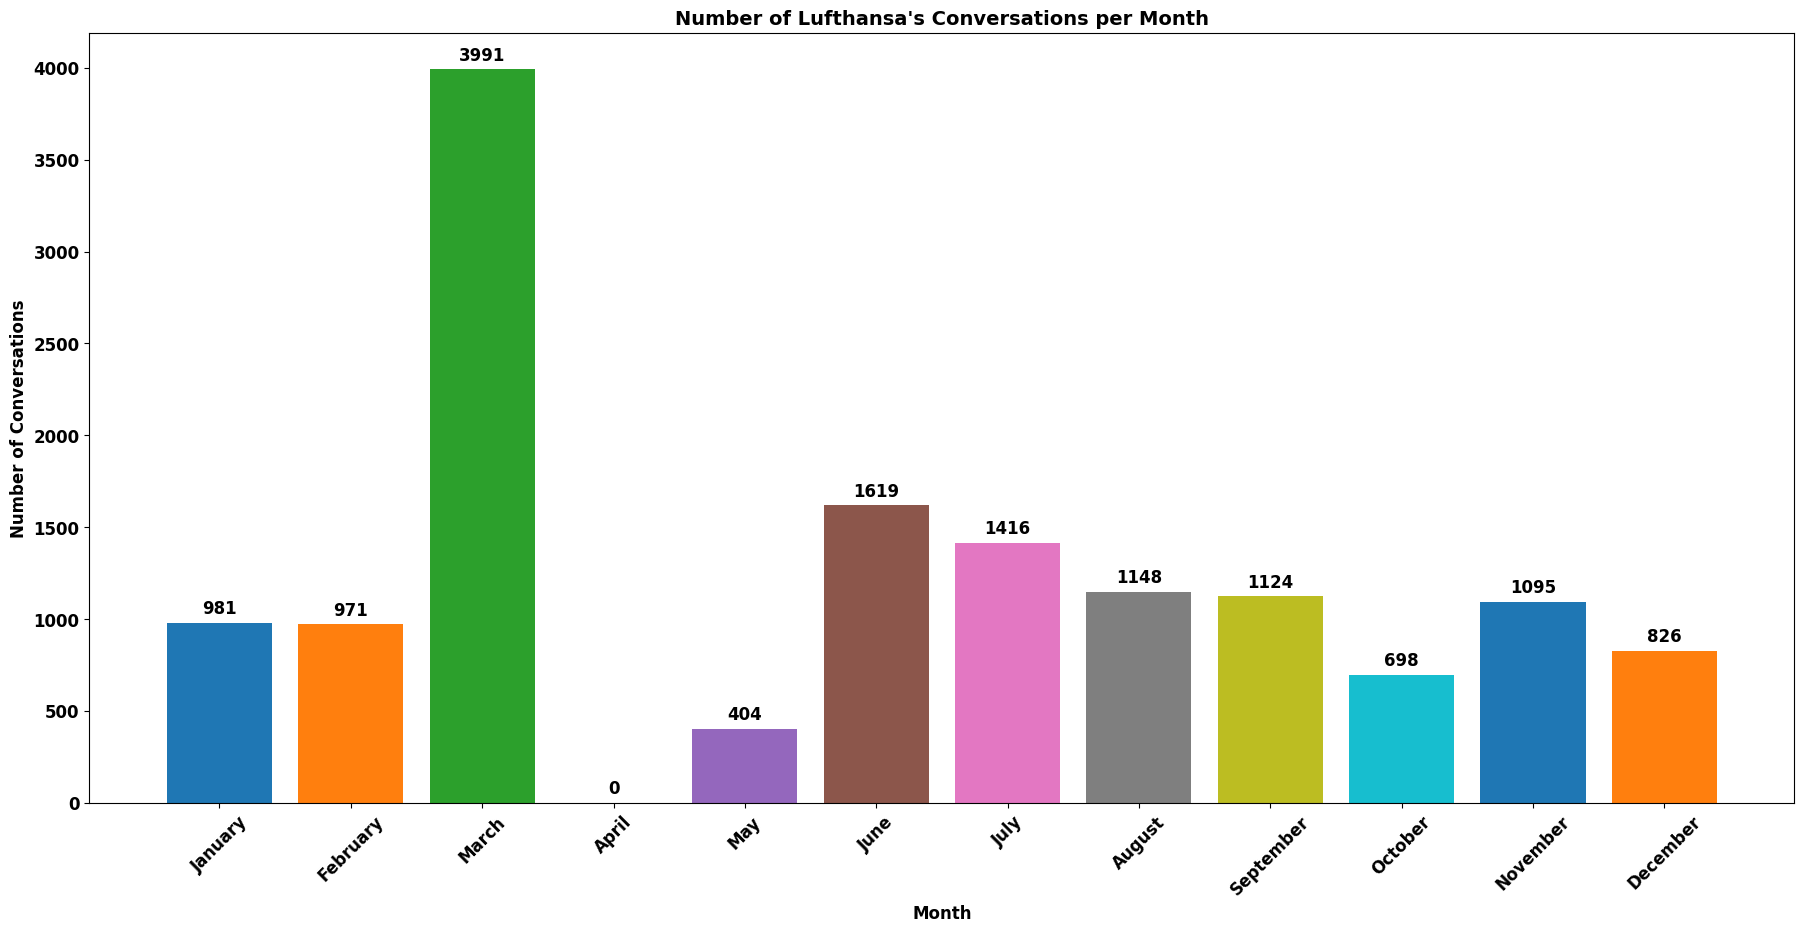

In [11]:
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the month name from the tweet creation time
first_tweet_times_month = first_tweet_times.dt.month_name()

# Group by month name and count the number of conversations
conversations_per_month = first_tweet_times_month.value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(22, 10))
bars = plt.bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title("Number of Lufthansa's Conversations per Month", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold');


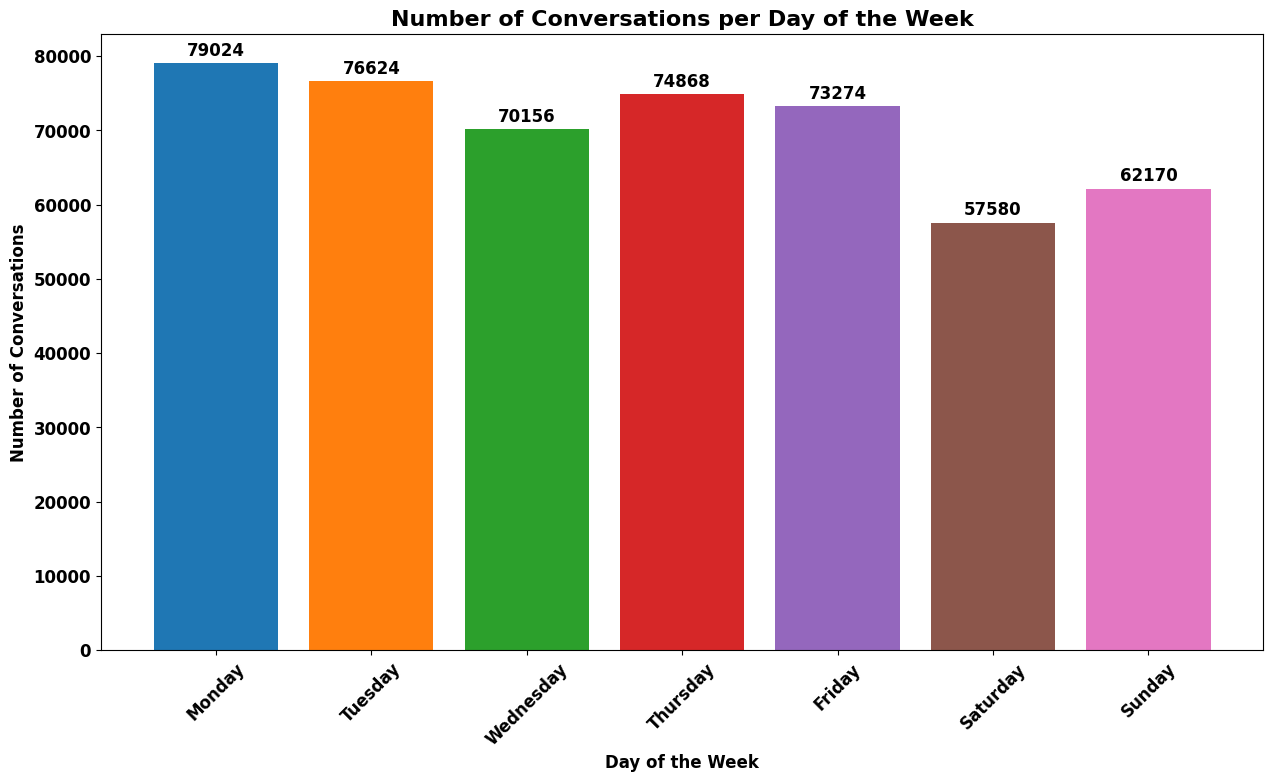

In [12]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the day name from the tweet creation time
first_tweet_times_day = first_tweet_times.dt.day_name()

# Group by day name and count the number of conversations
conversations_per_day = first_tweet_times_day.value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(conversations_per_day.index, conversations_per_day.values, color=colors[:len(conversations_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Day of the Week', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')


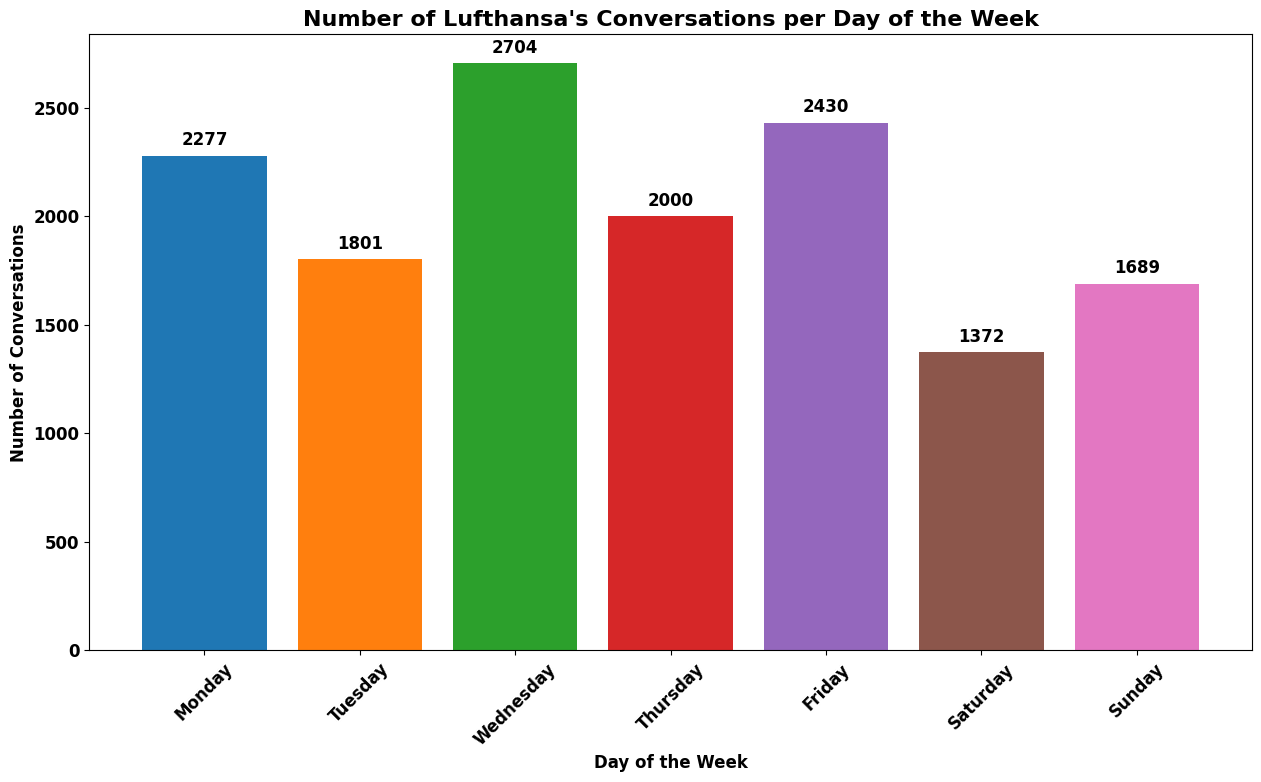

In [13]:
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])
# Ensure tweet_creation_time is in datetime format
df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the day name from the tweet creation time
first_tweet_times_day = first_tweet_times.dt.day_name()

# Group by day name and count the number of conversations
conversations_per_day = first_tweet_times_day.value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(conversations_per_day.index, conversations_per_day.values, color=colors[:len(conversations_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title("Number of Lufthansa's Conversations per Day of the Week", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold')


## Airline response time

C:\Users\Chekm\AppData\Local\Temp\ipykernel_6800\3596762615.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airline_replies['airline'] = airline_replies['user_id'].map(COMPANY_ID_TO_NAME)


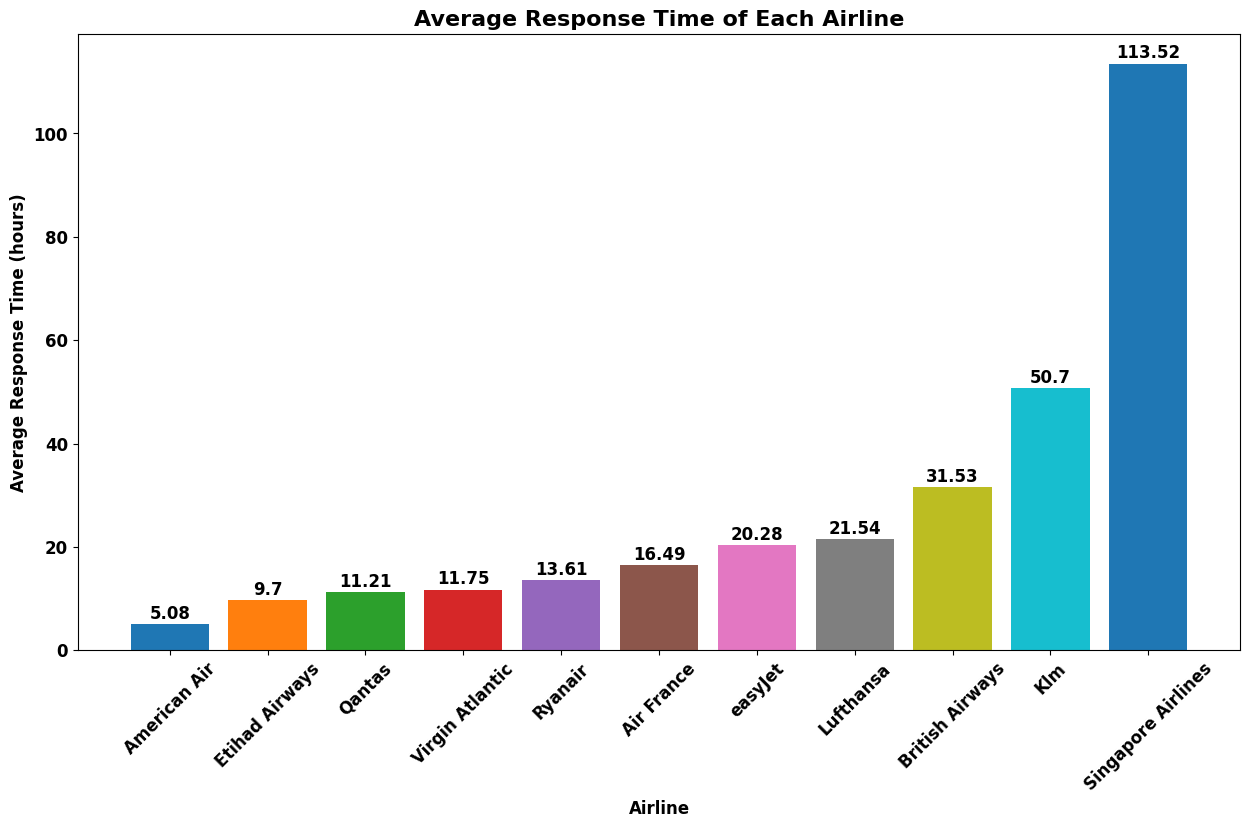

In [14]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for airline replies only
airline_replies = df_reset[df_reset['user_id'].isin(COMPANY_NAME_TO_ID.values()) & (df_reset['response_time'] > 0)]

# Simplified mapping of user IDs to airline names
airline_replies['airline'] = airline_replies['user_id'].map(COMPANY_ID_TO_NAME)

# Aggregate and compute the average response time for each airline
average_response_times = airline_replies.groupby('airline')['response_time'].mean().sort_values()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(average_response_times.index, average_response_times.values, color=colors[:len(average_response_times)])
plt.xlabel('Airline', fontsize=12, fontweight='bold')
plt.ylabel('Average Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Average Response Time of Each Airline', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


C:\Users\Chekm\AppData\Local\Temp\ipykernel_6800\43986986.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


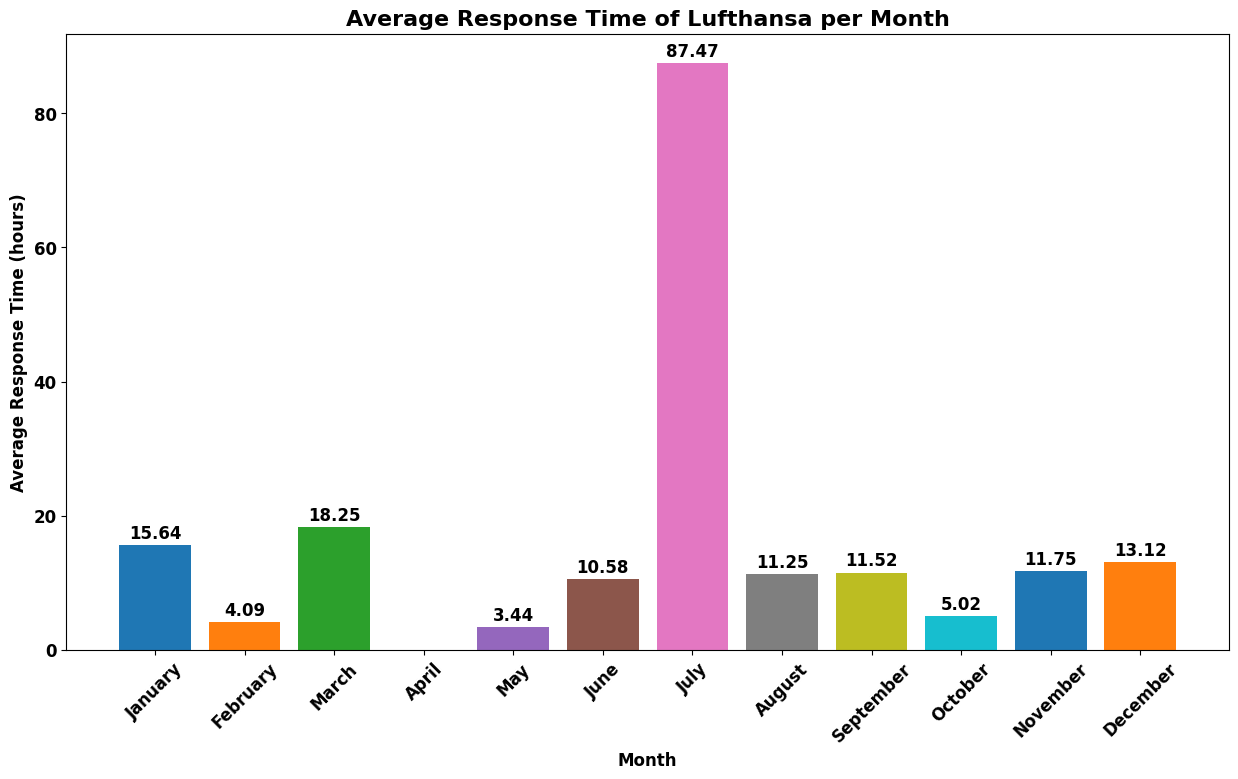

In [15]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_replies = df_reset[(df_reset['user_id'] == lufthansa_user_id) & (df_reset['response_time'] > 0)]

# Extract month from the tweet creation time
lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()

# Aggregate and compute the average response time for each month
average_response_times_per_month = lufthansa_replies.groupby('month')['response_time'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(average_response_times_per_month.index, average_response_times_per_month.values, color=colors[:len(average_response_times_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Average Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Average Response Time of Lufthansa per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


# Sentiment analysis

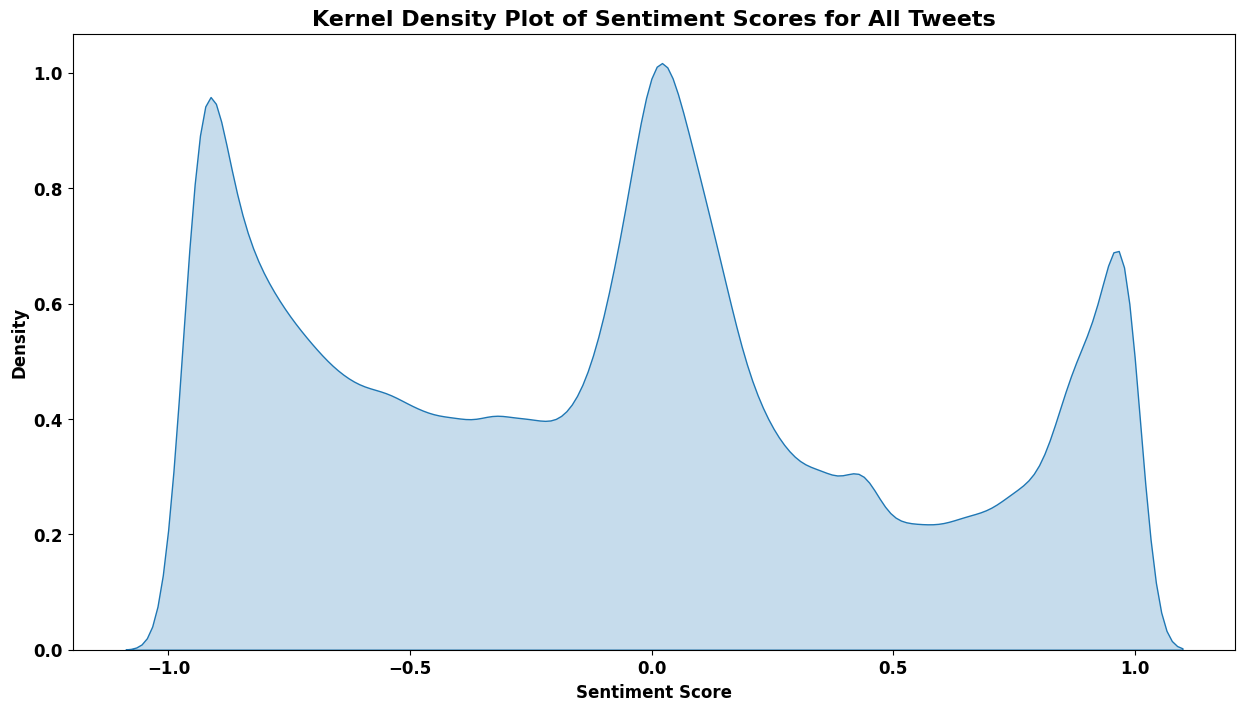

In [16]:
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Define a colormap
cmap = mcolors.TABLEAU_COLORS

# Plot the KDE plot
plt.figure(figsize=(15, 8))
sns.kdeplot(df_reset['sentiment_score'].dropna(), fill=True, color=list(cmap.values())[0])

plt.xlabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.title('Kernel Density Plot of Sentiment Scores for All Tweets', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold');

C:\Users\Chekm\AppData\Local\Temp\ipykernel_6800\320640737.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='airline', y='sentiment_score', data=airline_tweets, palette=palette)
c:\My programs\Python 3.12\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\My programs\Python 3.12\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\My programs\Python 3.12\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 li

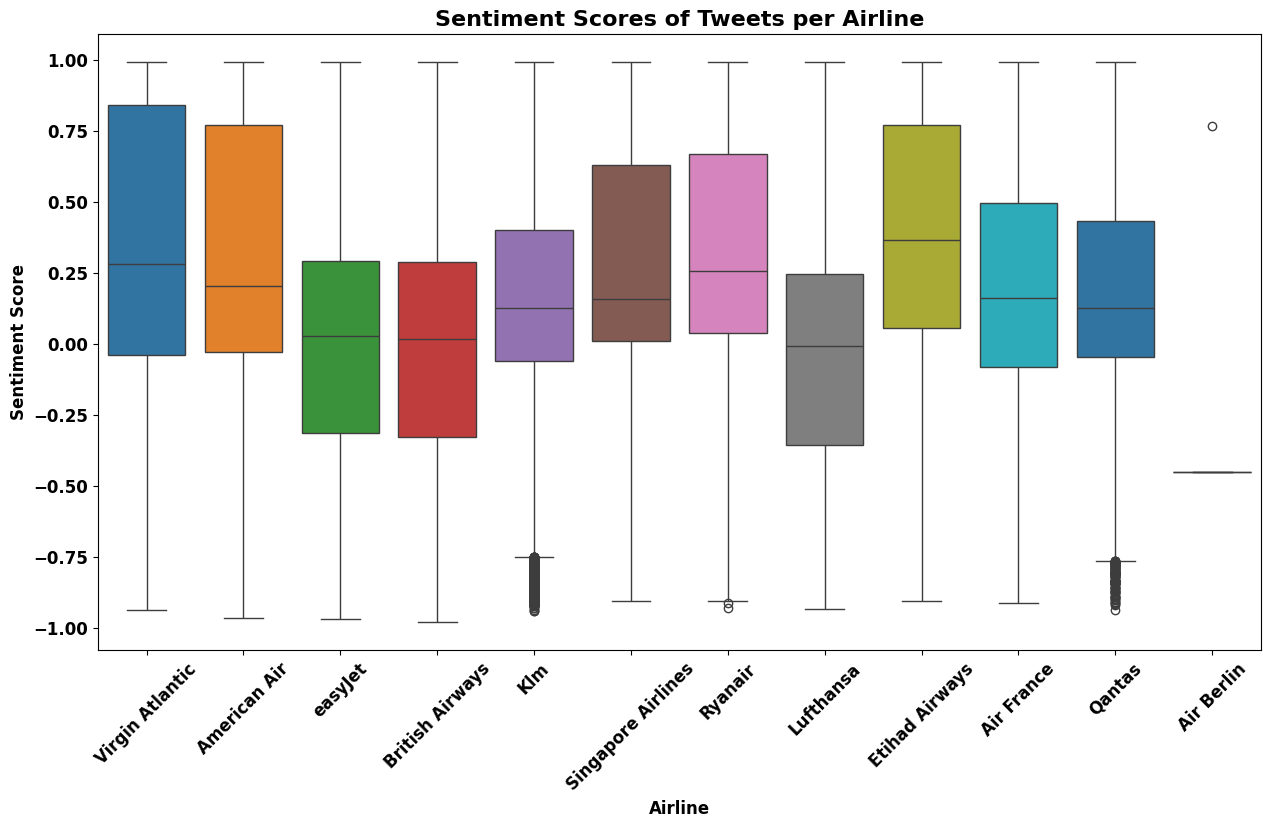

In [17]:
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Map user IDs to airline names
df_reset['airline'] = df_reset['user_id'].map(COMPANY_ID_TO_NAME)
# Filter the DataFrame to include only the tweets from the specified airlines
airline_tweets = df_reset[df_reset['airline'].notnull()]

# Define a color palette using mcolors
colors = list(mcolors.TABLEAU_COLORS.values())
palette = {airline: colors[i % len(colors)] for i, airline in enumerate(airline_tweets['airline'].unique())}

# Plot the box plot for sentiment scores grouped by airline
plt.figure(figsize=(15, 8))
sns.boxplot(x='airline', y='sentiment_score', data=airline_tweets, palette=palette)
plt.xlabel('Airline', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Sentiment Scores of Tweets per Airline', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold');


C:\Users\Chekm\AppData\Local\Temp\ipykernel_6800\618515429.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_tweets['month'] = customer_tweets['tweet_creation_time'].dt.month_name()


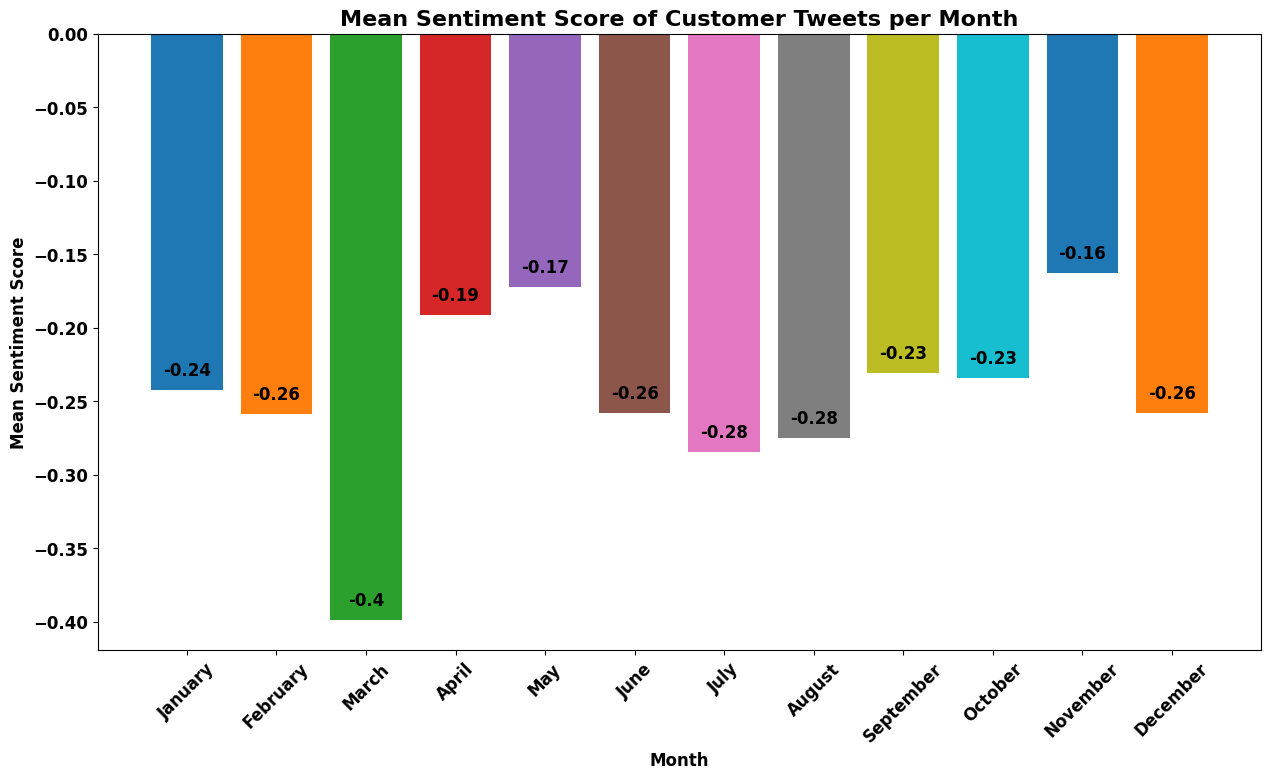

In [18]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Ensure sentiment_score is in numeric format
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Filter out the airline tweets to get only customer tweets
customer_tweets = df_reset[~df_reset['user_id'].isin(COMPANY_NAME_TO_ID.values())]

# Extract the month from the tweet creation time
customer_tweets['month'] = customer_tweets['tweet_creation_time'].dt.month_name()

# Group by month and calculate the mean sentiment score
mean_sentiment_per_month = customer_tweets.groupby('month')['sentiment_score'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(mean_sentiment_per_month.index, mean_sentiment_per_month.values, color=colors[:len(mean_sentiment_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Mean Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Mean Sentiment Score of Customer Tweets per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


C:\Users\Chekm\AppData\Local\Temp\ipykernel_6800\3070238913.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_tweets['day_of_week'] = customer_tweets['tweet_creation_time'].dt.day_name()


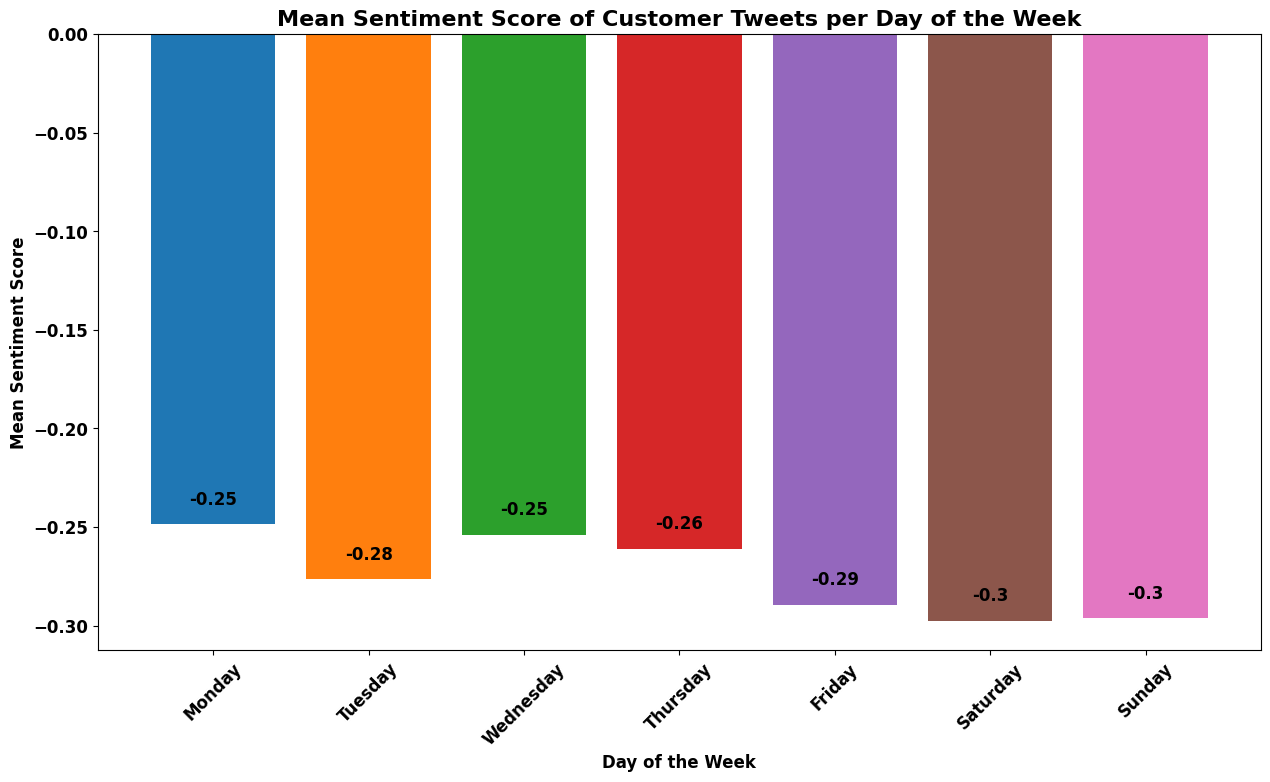

In [19]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Ensure sentiment_score is in numeric format
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Filter out the airline tweets to get only customer tweets
customer_tweets = df_reset[~df_reset['user_id'].isin(COMPANY_NAME_TO_ID.values())]

# Extract the day of the week from the tweet creation time
customer_tweets['day_of_week'] = customer_tweets['tweet_creation_time'].dt.day_name()

# Group by day of the week and calculate the mean sentiment score
mean_sentiment_per_day = customer_tweets.groupby('day_of_week')['sentiment_score'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(mean_sentiment_per_day.index, mean_sentiment_per_day.values, color=colors[:len(mean_sentiment_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Mean Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Mean Sentiment Score of Customer Tweets per Day of the Week', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


# Sentiment evolution

In [20]:
df_reset

,conversation_id,tweet_order,tweet_id,user_id,user_creation_time,tweet_creation_time,full_text,lang,country_code,sentiment_score,response_time,airline
0,1,1,1244694453190897664,521835883,2012-03-12 01:11:22+00:00,2020-03-30 18:34:17+00:00,@nealrach @VirginAtlantic Siiiigh.... Still no...,en,un,0.292771,0.000000,NaN
1,1,2,1244696682979303426,20626359,2009-02-11 20:50:56+00:00,2020-03-30 18:43:09+00:00,@Jade_Velveteese Hi Jade. We have an ‘Away fro...,en,un,0.190686,0.147778,Virgin Atlantic
2,2,1,1244677304598609923,396021583,2011-10-22 16:35:05+00:00,2020-03-30 17:26:09+00:00,@VirginAtlantic Sod off your primary sharehold...,en,un,-0.909571,0.000000,NaN
3,2,2,1244696641401163776,832964639436701696,2017-02-18 14:47:00+00:00,2020-03-30 18:42:59+00:00,"@Boyde11 @VirginAtlantic Get your facts right,...",en,un,0.058692,1.280556,NaN
4,3,1,1244644204132909060,274980475,2011-03-31 11:55:53+00:00,2020-03-30 15:14:37+00:00,@easyJet Please reply to my DM!,en,un,0.076921,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1346561,493694,3,452657442057646080,2198564846,2013-11-16 23:24:47+00:00,2014-04-06 04:01:58+00:00,@AmericanAir They cannot hear my screams,en,un,-0.830774,0.030000,NaN
1346562,493695,1,451124070730719233,701977520,2012-07-17 23:34:18+00:00,2014-04-01 22:28:54+00:00,@AmericanAir i was kidding thanks for the foll...,en,un,0.878425,0.000000,NaN
1346563,493695,2,451125255294443521,22536055,2009-03-02 21:23:05+00:00,2014-04-01 22:33:37+00:00,@lanaupdates_ Your information has been forwar...,en,un,0.246197,0.078611,American Air
1346564,493696,1,430790355962052608,64327804,2009-08-10 03:34:27+00:00,2014-02-04 19:49:59+00:00,"@AmericanAir phew, they finally turned on the ...",en,un,0.155998,0.000000,NaN


In [21]:
# Group by 'Conversation' and 'user_id' to get the first and last sentiment scores
grouped = df_reset.groupby(['conversation_id', 'user_id'])

# Calculate the first and last sentiment scores
first_last_sentiments = grouped['sentiment_score'].agg(['first', 'last']).reset_index()

# Calculate the change in sentiment score
first_last_sentiments['change_in_sentiment'] = first_last_sentiments['last'] - first_last_sentiments['first']
# df_conversations_full = df_conversations_full.merge(first_last_sentiments[['Conversation', 'user_id', 'change_in_sentiment']], on=['Conversation', 'user_id'], how='left')
first_last_sentiments[["conversation_id", "user_id", "change_in_sentiment"]]

,conversation_id,user_id,change_in_sentiment
0,1,20626359,0.0
1,1,521835883,0.0
2,2,396021583,0.0
3,2,832964639436701696,0.0
4,3,274980475,0.0
...,...,...,...
987387,493694,22536055,0.0
987388,493695,22536055,0.0
987389,493695,701977520,0.0
987390,493696,22536055,0.0


In [22]:
average_sentiment_per_user = df_reset.groupby(['conversation_id', 'user_id']).agg(
    tweets_number=("sentiment_score", "count"),
    average_sentiment=("sentiment_score", "mean"),
    min_sentiment=("sentiment_score", "min"),
    max_sentiment=("sentiment_score", "max"),
).reset_index()

# Merge first_last_sentiments with average_sentiment_per_user
merged_df = pd.merge(average_sentiment_per_user, first_last_sentiments[['conversation_id', 'user_id', 'change_in_sentiment']],
                     on=['conversation_id', 'user_id'], how='left')

In [23]:
merged_df

,conversation_id,user_id,tweets_number,average_sentiment,min_sentiment,max_sentiment,change_in_sentiment
0,1,20626359,1,0.190686,0.190686,0.190686,0.0
1,1,521835883,1,0.292771,0.292771,0.292771,0.0
2,2,396021583,1,-0.909571,-0.909571,-0.909571,0.0
3,2,832964639436701696,1,0.058692,0.058692,0.058692,0.0
4,3,274980475,1,0.076921,0.076921,0.076921,0.0
...,...,...,...,...,...,...,...
987387,493694,22536055,1,0.024142,0.024142,0.024142,0.0
987388,493695,22536055,1,0.246197,0.246197,0.246197,0.0
987389,493695,701977520,1,0.878425,0.878425,0.878425,0.0
987390,493696,22536055,1,0.486518,0.486518,0.486518,0.0


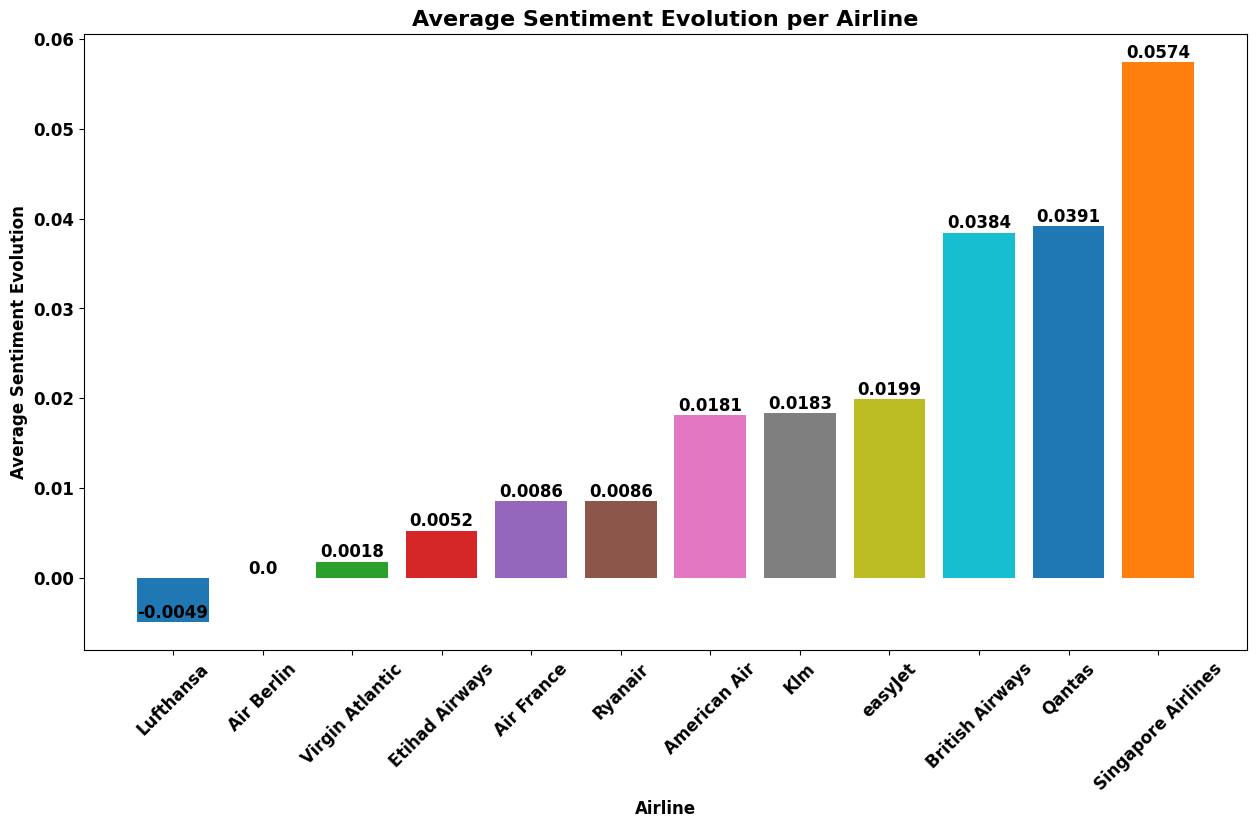

In [24]:
merged_df['airline'] = merged_df['user_id'].map(COMPANY_ID_TO_NAME)

# Filter the DataFrame to include only the tweets from the specified airlines
airline_tweets = merged_df[merged_df['airline'].notnull()]

# Group by airline and calculate the average change in sentiment
average_change_in_sentiment = airline_tweets.groupby('airline')['change_in_sentiment'].mean().sort_values()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(average_change_in_sentiment.index, average_change_in_sentiment.values, color=colors[:len(average_change_in_sentiment)])
plt.xlabel('Airline', fontsize=12, fontweight='bold')
plt.ylabel('Average Sentiment Evolution', fontsize=12, fontweight='bold')
plt.title('Average Sentiment Evolution per Airline', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval +0.0005, round(yval, 4), ha='center', fontsize=12, fontweight='bold')


# Categorization